# Goal: create a circular search polygon around a user defined geographic point coordinate with a given search radius in meters

**Input:** longitude and latitude of search center in decimal degrees and search radius in meters
* latitude  must be in decimal degrees and between ±90° latitude.
* longitude must be in decimal degrees degrees east and can be between 0° and 360° or ±180°
  Note: longitude will be wrapped to ±180°
  
**Output:** circular search polyon in GeoJSON format

**Caveats:**
* crossing the poles at ±90° has not been tested and may produce unexpected results.
* crossing the prime meridian at ±180° has not been tested and may produce unexpected results.

In [1]:
# load required modules
import pyproj
import shapely
import numpy as np
from functools import partial
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
# the two lines before importing GeoPandas are to turn off a warning message and tell GeoPandas to use Shapely instead of PyGEOS
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

# define some parameters
earth_radius_sphere_m = 6371007 # Earth's radius of an authalic sphere in meters 

In [2]:
# get geographic point coordinates and search distance for spatial search

lat_ctr =  69.0285674715518
lon_ctr = -49.4797934493365
search_radius_m = 5000.0

# need to wrap longitudes to ±180° for exporting geographic coordinates
# 0 to 360 is not supported
if np.abs(lon_ctr) > 180:
    lon_ctr = np.mod(lon_ctr - 180.0, 360.0) - 180.0

In [3]:
# define local projection with search coordinates as center in proj4 syntax
local_map_proj = "+proj=stere +R={} +units=m +lat_0={} +lon_0={}".format(earth_radius_sphere_m, lat_ctr, lon_ctr)
print(f'local map projection used for buffer calculation: {local_map_proj}')

local map projection used for buffer calculation: +proj=stere +R=6371007 +units=m +lat_0=69.0285674715518 +lon_0=-49.4797934493365


In [4]:
# define local forward and inverse map projections
# works for now but fix warning message by replacing proj 1 style with proj 2 style for coordinate transformations:
# see https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

ll_to_xy = partial(
    pyproj.transform,
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    pyproj.Proj(local_map_proj),
)
xy_to_ll = partial(
    pyproj.transform,
    pyproj.Proj(local_map_proj),
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
)

#from pyproj import Transformer

#transformer_ll_to_xy = Transformer.from_crs("EPSG:4326",local_map_proj)
#transformer_xy_to_ll = Transformer.from_crs(local_map_proj,"EPSG:4326")

In [5]:
# create circular polygon with desired search radius and transform back to geopgraphic coordinates
search_center_ll = Point(float(lon_ctr), float(lat_ctr))
search_center_xy = transform(ll_to_xy, search_center_ll)
search_buffer_xy = search_center_xy.buffer(search_radius_m)

# get the polygon with lat lon coordinates
search_buffer_ll = transform(xy_to_ll, search_buffer_xy)
# convert search buffer into a shapely polygon
search_polygon_ll = Polygon(search_buffer_ll)

#x_ctr, y_ctr = transformer_ll_to_xy.transform(float(lon_ctr), float(lat_ctr))
#search_center_xy = Point(x_ctr, y_ctr)
#search_buffer_xy = search_center_xy.buffer(search_radius_m)
# extract the vertices that define the perimeter of the search polygon
#x_poly, y_poly = search_buffer_xy.exterior.coords.xy

#lon_poly, lat_poly = transformer_xy_to_ll.transform(x_poly, y_poly)

#search_polygon_ll = Polygon(zip(lon_poly, lat_poly))


/srv/conda/envs/notebook/lib/python3.10/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/srv/conda/envs/notebook/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


In [6]:
# create GeoDataFrame with coordinate reference system and geometry fields from search polygon
search_circle_gdf = gpd.GeoDataFrame(index = [0], crs = 'epsg:4326', geometry = [search_polygon_ll])

In [7]:
# save GeoJSON file
search_circle_gdf.to_file("search_circle_ll.geojson", driver="GeoJSON")  

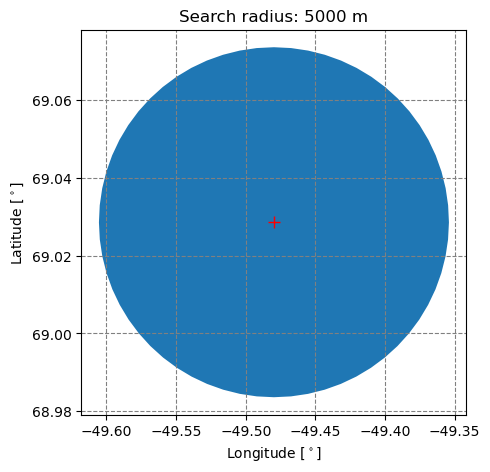

In [8]:
# make a simple plot of the search polygon in geopgraphical coordinates
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(5, 5))                    # create an empty Matplotlib figure with axes
search_circle_gdf.plot(ax=axs)                             # use pandas to plot the polygon on the existing figure
axs.plot(lon_ctr, lat_ctr, '+', markersize = 8,color = 'r', lw = 8, label='search center')
axs.set_ylabel("Latitude [$^\circ$]")                      # customize plot
axs.set_xlabel("Longitude [$^\circ$]")
axs.grid(True)
axs.grid(color='gray', linestyle='--', linewidth=0.80)
axs.set_title(f"Search radius: {search_radius_m:.0f} m")
fig.savefig("search_polygon_map.png")                      # save the figure
plt.show()                                                 # display plot

In [9]:
# plot search polygon with OpenStreetMap as basemap
search_circle_gdf.explore()